In [52]:
import subprocess

input_file = "ai.ja.txt"
output_file = "ai.ja.txt.parsed"

# -f1 を指定して正しいフォーマットで出力
with open(input_file, "r", encoding="utf-8") as f_in, open(output_file, "w", encoding="utf-8") as f_out:
    result = subprocess.run(["cabocha", "-f1"], stdin=f_in, stdout=f_out, text=True)

print("CaboCha の解析が完了しました（正しいフォーマットに変換）。")



CaboCha の解析が完了しました（正しいフォーマットに変換）。


In [54]:
with open("ai.ja.txt.parsed", "r", encoding="utf-8") as f:
    for _ in range(20):
        print(f.readline().strip())



* 0 -1D 1/1 0.000000
人工	名詞,一般,*,*,*,*,人工,ジンコウ,ジンコー
知能	名詞,一般,*,*,*,*,知能,チノウ,チノー
EOS
EOS
* 0 17D 1/1 0.388993
人工	名詞,一般,*,*,*,*,人工,ジンコウ,ジンコー
知能	名詞,一般,*,*,*,*,知能,チノウ,チノー
* 1 17D 2/3 0.613549
（	記号,括弧開,*,*,*,*,（,（,（
じん	名詞,一般,*,*,*,*,じん,ジン,ジン
こうち	名詞,一般,*,*,*,*,こうち,コウチ,コーチ
のう	助詞,終助詞,*,*,*,*,のう,ノウ,ノー
、	記号,読点,*,*,*,*,、,、,、
、	記号,読点,*,*,*,*,、,、,、
* 2 3D 0/0 0.758984
AI	名詞,一般,*,*,*,*,*
* 3 17D 1/5 0.517898
〈	記号,括弧開,*,*,*,*,〈,〈,〈
エーアイ	名詞,固有名詞,一般,*,*,*,*


### 40. 係り受け解析結果の読み込み（形態素）
形態素解析は、文章を「形態素」という最小単位に分解する処理。  
形態素は単語や記号など、意味を持つ基本的な単位。  
#### Morphクラス
各形態素（単語）に対して、「表層形（実際に出現した文字列）」「基本形（辞書に載っている基本の形）」「品詞（名詞、動詞など）」「品詞細分類1」の4つの情報を保持するようにする
#### ファイルの読み込み
解析結果ファイルは、1行ずつ読んで、行が "EOS" になれば1文の終了とみなし、文ごとに形態素のリストを作る  


In [127]:
class Morph:
    def __init__(self, surface, base, pos, pos1):
        self.surface = surface  # 表層形
        self.base = base        # 基本形
        self.pos = pos          # 品詞
        self.pos1 = pos1        # 品詞細分類1

    def __repr__(self):
        return f"Morph({self.surface}, {self.base}, {self.pos}, {self.pos1})"

def parse_morphs(filename):
    """
    ファイルを読み込み，1文をMorphオブジェクトのリストとして返す．
    ※行頭が"*"の行は文節情報なので無視する．
    """
    sentences = []
    morphs = []
    with open(filename, encoding="utf-8") as f:
        for line in f:
            line = line.rstrip("\n")
            if line == "EOS":
                if morphs:
                    sentences.append(morphs)
                    morphs = []
            elif line.startswith("*"):
                continue
            else:
                # 行の形式: 表層形\t品詞,品詞細分類1,*,*,*,*,基本形,読み,発音
                surface, rest = line.split("\t")
                cols = rest.split(",")
                morph = Morph(surface, cols[6], cols[0], cols[1])
                morphs.append(morph)
    return sentences

# 解析結果ファイルから文ごとのMorphリストを取得し，先頭文の形態素列（表層形）を表示
sentences = parse_morphs("ai.ja.txt.parsed")
first_sentence = sentences[0]
print(" ".join(m.surface for m in first_sentence))


人工 知能


### 41. 係り受け解析結果の読み込み（文節・係り受け）
文節とは、複数の形態素が結びついたまとまりのことで、文章中の意味や文法上のまとまり（例えば、名詞句や動詞句）を表す  
また、各文節同士の「係り受け関係」が解析結果に含まれており、どの文節がどの文節にかかっているかが記録されている
#### Chunkクラス
Morph オブジェクトのリストに加え、係り先の文節番号（dst）や、後で使う係り元の文節番号（srcs）をメンバ変数として持つ Chunk クラスを実装。
#### ファイルの読み込み
ファイルを読み込むとき、行が "*" で始まる場合は文節の始まりと判断し、その行から文節番号や係り先の情報を取り出す  
文節に属する各形態素の情報を読み込み、Chunk オブジェクトに追加していく  
1文の終了時に、各文節の srcs（係り元の文節番号）も更新

In [101]:
class Chunk:
    def __init__(self, dst):
        self.morphs = []  # この文節に含まれるMorphオブジェクトのリスト
        self.dst = dst    # 係り先文節インデックス (-1 は係り先無し)
        self.srcs = []    # 係り元文節インデックスのリスト

    def get_text(self):
        """記号以外の形態素の表層形を連結して文節の文字列を返す"""
        return "".join(m.surface for m in self.morphs if m.pos != "記号")

def parse_chunks(filename):
    """
    ファイルを読み込み，1文をChunkオブジェクトのリストとして返す．
    文末のEOSごとに1文とする．
    """
    sentences = []
    chunks = dict()
    idx = -1
    with open(filename, encoding="utf-8") as f:
        for line in f:
            line = line.rstrip("\n")
            if line == "EOS":
                if chunks:
                    # インデックス順にChunkオブジェクトを並べる
                    sorted_chunks = [chunks[i] for i in sorted(chunks.keys())]
                    # 各Chunkのsrcsを設定
                    for i, chunk in enumerate(sorted_chunks):
                        if chunk.dst != -1:
                            sorted_chunks[chunk.dst].srcs.append(i)
                    sentences.append(sorted_chunks)
                    chunks = dict()
                    idx = -1
            elif line.startswith("*"):
                # 文節の始まり：例 "* 0 2D ..." → 文節番号0, 係り先は2
                cols = line.split()
                idx = int(cols[1])
                dst = int(cols[2].rstrip("D"))
                chunks[idx] = Chunk(dst)
            else:
                surface, rest = line.split("\t")
                cols = rest.split(",")
                morph = Morph(surface, cols[6], cols[0], cols[1])
                chunks[idx].morphs.append(morph)
    return sentences

# 解析結果ファイルから文ごとのChunkリストを取得し，先頭文の各文節の文字列と係り先を表示
chunks_sentences = parse_chunks("ai.ja.txt.parsed")
first_chunks = chunks_sentences[0]
print("【タスク41】先頭文の各文節と係り先:")
for chunk in first_chunks:
    print(f"{chunk.get_text()}\t{chunk.dst}")


【タスク41】先頭文の各文節と係り先:
人工知能	-1


### 42. 係り元と係り先の文節の表示
文中で実際にどの文節がどの文節に係っているか（依存関係）を確認する  
出力では、係り元（出発点）と係り先（向かう先）の文節をタブ区切りで表示し、記号などは除いて見やすくしている
#### 解法
すでに読み込んだ Chunk オブジェクトを使い、各文節の dst が -1 でない（つまり、どこかに係っている）場合に、  
・係り元の文節（現在のChunk）と  
・係り先の文節（dst 番号の Chunk）の文字列を表示

In [131]:
for chunks in chunks_sentences:
    for chunk in chunks:
        if chunk.dst != -1:
            print(f"{chunk.get_text()}\t{chunks[chunk.dst].get_text()}")


人工知能	語
じんこうちのう	語
AI	エーアイとは
エーアイとは	語
計算	という
という	道具を
概念と	道具を
コンピュータ	という
という	道具を
道具を	用いて
用いて	研究する
知能を	研究する
研究する	計算機科学
計算機科学	の
の	一分野を
一分野を	指す
指す	語
語	研究分野とも
言語の	推論
理解や	推論
推論	問題解決などの
問題解決などの	知的行動を
知的行動を	代わって
人間に	代わって
代わって	行わせる
コンピューターに	行わせる
行わせる	技術または
技術または	研究分野とも
計算機	コンピュータによる
コンピュータによる	情報処理システムの
知的な	情報処理システムの
情報処理システムの	実現に関する
設計や	実現に関する
実現に関する	研究分野とも
研究分野とも	される
日本大百科全書(ニッポニカ)』の	解説で
解説で	述べている
情報工学者通信工学者の	佐藤理史は
佐藤理史は	述べている
次のように	述べている
人間の	知的能力を
知的能力を	実現する
コンピュータ上で	実現する
実現する	技術ソフトウェアコンピュータシステム
様々な	技術ソフトウェアコンピュータシステム
技術ソフトウェアコンピュータシステム	ある
応用例は	ある
自然言語処理	機械翻訳かな漢字変換構文解析等
機械翻訳かな漢字変換構文解析等	専門家の
専門家の	推論判断を
推論判断を	模倣する
模倣する	エキスパートシステム
エキスパートシステム	画像認識等が
画像データを	解析して
解析して	検出抽出したりする
特定の	パターンを
パターンを	検出抽出したりする
検出抽出したりする	画像認識等が
画像認識等が	ある
ある	命名された
1956年に	命名された
ダートマス会議で	命名された
ジョンマッカーシーにより	命名された
命名された	使われている
現在では	使われている
記号処理を	用いた
用いた	知能の
知能の	記述を
記述を	する
主体と	する
する	研究での
情報処理や	研究での
研究での	アプローチという
アプローチという	意味あいでも
意味あいでも	使われている
使われている	ある
家庭用電気機械器具の	制御システムや
制御システムや	思考ルーチンも
ゲームソフトの	思考ルーチンも
思考ルーチンも	呼ばれる
こう	呼ばれる
呼ばれる	ことも


### 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
日本語の文では、名詞を含む文節（例えば、主語や目的語）が、動詞を含む文節（述語）にかかるという構造が一般的  
このタスクでは、名詞を含む文節が、係り先の文節に動詞が含まれている場合にそのペアを抽出して表示
#### 解法
各文節を調べ、もしその文節に「名詞」が含まれていた場合、  
その文節がどこに係っているか（dst）の文節に「動詞」が含まれているかを確認し、該当する場合に両方の文節の文字列を表示

In [134]:
for chunks in chunks_sentences:
    for chunk in chunks:
        if any(m.pos == "名詞" for m in chunk.morphs):
            if chunk.dst != -1:
                dst_chunk = chunks[chunk.dst]
                if any(m.pos == "動詞" for m in dst_chunk.morphs):
                    print(f"{chunk.get_text()}\t{dst_chunk.get_text()}")

道具を	用いて
知能を	研究する
一分野を	指す
知的行動を	代わって
人間に	代わって
コンピューターに	行わせる
研究分野とも	される
解説で	述べている
佐藤理史は	述べている
次のように	述べている
知的能力を	実現する
コンピュータ上で	実現する
技術ソフトウェアコンピュータシステム	ある
応用例は	ある
推論判断を	模倣する
画像データを	解析して
解析して	検出抽出したりする
パターンを	検出抽出したりする
画像認識等が	ある
1956年に	命名された
ダートマス会議で	命名された
ジョンマッカーシーにより	命名された
命名された	使われている
現在では	使われている
記号処理を	用いた
記述を	する
主体と	する
意味あいでも	使われている
思考ルーチンも	呼ばれる
ことも	ある
カウンセラーを	模倣した
プログラム	出されるが
人工無脳が	出されるが
引き合いに	出されるが
計算機に	させようという
役割を	させようという
エキスパートシステムと	呼ばれる
実現は	困難視されている
人間が	持つ
暗黙に	持つ
記述が	なり
問題と	なり
利用が	困難視されている
困難視されている	ある
アプローチとしては	知られているが
アプローチも	知られているが
差は	ある
記号的明示性に	ある
その後	集めた
サポートベクターマシンが	集めた
注目を	集めた
経験を	行う
元に	行う
学習を	行う
手法も	ある
宇宙において	実装するという
言葉通り	実装するという
知性を	表現し
機械的に	表現し
表現し	実装するという
登場により	行った
流行を	超えて
社会に	浸透して
浸透して	行った
2017年にかけて	導入した
ディープラーニングを	導入した
プレイヤーも	破り
麻雀では	なった
MicrosoftSuphx(SuperPhoenix)」が	到達するなど
AIとして	到達するなど
十段に	到達するなど
到達するなど	なった
最先端技術と	なった
人工知能は	呼ばれ
機械学習と	呼ばれ
ものが	ある
学習を	繰り返す
ことを	している
基本と	している
システム	関係している
経験に	基づく
手法であり	関係している
ソフトコンピューティングと	関係している
関係している	ある
手法としては	ある
ものが	ある
これらを	統合した
知的システムを	

### 44. 係り受け木の可視化
係り受け木（dependency tree）は、文の中でどの文節がどの文節に依存しているかを示す木構造  


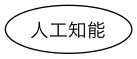

In [107]:
from graphviz import Digraph
from IPython.display import Image

# 先頭文のChunkリストを対象とする
sentence_to_visualize = first_chunks

dot = Digraph()
for i, chunk in enumerate(sentence_to_visualize):
    # ノードラベルは記号を除いた文節文字列
    dot.node(str(i), chunk.get_text())
for i, chunk in enumerate(sentence_to_visualize):
    if chunk.dst != -1:
        dot.edge(str(i), str(chunk.dst))

# 画像ファイルとして出力（dependency_tree.png）し表示
dot.render("dependency_tree", format="png", cleanup=True)
Image("dependency_tree.png")


In [97]:
# 文節のテキストと係り受けを表示
for chunk_id, chunk in sentences[0].items():
    print(f"{chunk_id}: {chunk.get_text()} -> {sentences[0][chunk.dst].get_text() if chunk.dst != -1 else 'なし'}")


0: 人工知能 -> なし


### 45. 動詞の格パターンの抽出
日本語の述語（動詞）が取る「格」は、文節に含まれる助詞（例：「は」「が」「を」など）で示される  
複数の文節が1つの動詞に係る場合、それぞれの文節に含まれる助詞（格助詞）を調べ、そのパターン（組み合わせ）を知ることで、述語の用法や意味のパターンがわかる
#### 解法
各文節で「動詞」を含む文節を見つけ、最も左に出現する動詞の基本形を述語として選ぶ
次に、その文節に係っている文節（srcs）の中から、助詞（m.pos == "助詞") を抽出し、複数あれば辞書順に並べ替え  
述語と格（助詞）の組み合わせをタブ区切りで表示


In [110]:
for chunks in chunks_sentences:
    for chunk in chunks:
        verbs = [m for m in chunk.morphs if m.pos == "動詞"]
        if verbs:
            predicate = verbs[0].base  # 最左の動詞の基本形
            particles = []
            # 係り元文節から助詞を抽出
            for src in chunk.srcs:
                src_particles = [m.surface for m in chunks[src].morphs if m.pos == "助詞"]
                if src_particles:
                    particles.append(src_particles[-1])
            if particles:
                particles = sorted(particles)
                print(f"{predicate}\t{' '.join(particles)}")

【タスク45】述語と格パターン:
用いる	を
する	て を
指す	を
代わる	に を
行う	て に
する	も
述べる	で に は
する	で を
する	を
する	を
する	て を
ある	が は
する	で に により
用いる	を
する	と を
使う	でも は
呼ぶ	も
ある	て も
する	を
出す	が に
する	に を
呼ぶ	と
持つ	が に
なる	が と
する	が が は
知る	は も
ある	が て に は
集める	が を
行う	に を を
ある	も
する	に を
する	において
超える	を
する	て に
行く	て により
する	にかけて を
破る	も
する	が として に
なる	と など は
呼ぶ	と は
ある	が
繰り返す	を
する	と を
基づく	に
する	と
ある	が て は
する	を
作る	を
なす	も
する	て に は を を を通して
上回る	で を
出す	を
行う	が て に は
でる	が
する	て て で は
だす	が で を
加える	に
見せる	て て において は を
広がる	が に は
行う	を
始まる	て て も
する	と
なる	が が と
する	が と
する	は を
行う	は を
する	を
もたらす	に は を
する	に
題する	と
する	に は を
築く	を
なる	に
出る	が と に関して
作り出す	で は を
する	は を
する	を
する	として は を
する	を
行う	を
行う	に
する	として において
する	として
示す	で に は を
する	を
示す	て は を
する	は を
する	は を
示す	を
呼ぶ	と
ある	は も
する	に を
する	を
使う	に によって は
する	が に は を
上げる	が で は を
する	に
する	に は を
打つ	に を
敗れる	が で に は は
する	において を
使う	のに を
省く	によって
上回る	が を
する	は を
する	が に
する	は も
する	が が に
する	が は
適す	に
する	から に対して を
行う	を
する	が が
行う	に に により を
する	が
する	に を
行う	て に を
する	に を
する	を
含む	は も
分かる	から が
する	が に
見合う	に
見出せる	が
する	から が は は も
する	が に は
進む	が
する	に につれて
する	を

### 46. 動詞の格フレーム情報の抽出
45の問題に加え、どのような文節（項＝argument）が述語に係っているのか、具体的な単語列（文節の文字列）も出力  
これにより、動詞の「格フレーム情報」が得られる
#### 解法
タスク45の方法を拡張し、係る文節からは助詞だけでなく、その文節全体の文字列（記号を除いた形）も同時に取得  
助詞と対応する項を同じ順序で並べ、タブ区切りで「述語」「格パターン」「項」として出力

In [113]:
for chunks in chunks_sentences:
    for chunk in chunks:
        verbs = [m for m in chunk.morphs if m.pos == "動詞"]
        if verbs:
            predicate = verbs[0].base
            pairs = []
            for src in chunk.srcs:
                src_particles = [m.surface for m in chunks[src].morphs if m.pos == "助詞"]
                if src_particles:
                    # ここでは，文節内の最後の助詞を用いる
                    pairs.append((src_particles[-1], chunks[src].get_text()))
            if pairs:
                pairs.sort(key=lambda x: x[0])
                particles_sorted = " ".join(p for p, _ in pairs)
                phrases_sorted = " ".join(ph for _, ph in pairs)
                print(f"{predicate}\t{particles_sorted}\t{phrases_sorted}")

用いる	を	道具を
する	て を	用いて 知能を
指す	を	一分野を
代わる	に を	人間に 知的行動を
行う	て に	代わって コンピューターに
する	も	研究分野とも
述べる	で に は	解説で 次のように 佐藤理史は
する	で を	コンピュータ上で 知的能力を
する	を	推論判断を
する	を	画像データを
する	て を	解析して パターンを
ある	が は	画像認識等が 応用例は
する	で に により	ダートマス会議で 1956年に ジョンマッカーシーにより
用いる	を	記号処理を
する	と を	主体と 記述を
使う	でも は	意味あいでも 現在では
呼ぶ	も	思考ルーチンも
ある	て も	使われている ことも
する	を	カウンセラーを
出す	が に	人工無脳が 引き合いに
する	に を	計算機に 役割を
呼ぶ	と	エキスパートシステムと
持つ	が に	人間が 暗黙に
なる	が と	記述が 問題と
する	が が は	出されるが 利用が 実現は
知る	は も	アプローチとしては アプローチも
ある	が て に は	知られているが 困難視されている 記号的明示性に 差は
集める	が を	サポートベクターマシンが 注目を
行う	に を を	元に 経験を 学習を
ある	も	手法も
する	に を	機械的に 知性を
する	において	宇宙において
超える	を	流行を
する	て に	超えて 社会に
行く	て により	浸透して 登場により
する	にかけて を	2017年にかけて ディープラーニングを
破る	も	プレイヤーも
する	が として に	MicrosoftSuphx(SuperPhoenix)」が AIとして 十段に
なる	と など は	最先端技術と 到達するなど 麻雀では
呼ぶ	と は	機械学習と 人工知能は
ある	が	ものが
繰り返す	を	学習を
する	と を	基本と ことを
基づく	に	経験に
する	と	ソフトコンピューティングと
ある	が て は	ものが 関係している 手法としては
する	を	これらを
作る	を	知的システムを
なす	も	試みも
する	て に は を を を通して	なされている 元に ACT-Rでは 推論ルールを 統計的学習を 生成規則を通して
上回る	で を	領域で 人工知能を
出す	を	精度を
行う	が て に は	研究が 出しており 盛んに 

### 47. 機能動詞構文のマイニング
日本語には「サ変接続名詞＋を＋動詞」という特定の構文があり、これを機能動詞構文と呼ぶ  
この構文は、動詞とその補助的な名詞句の組み合わせで意味が成立するため、抽出することで特有の言い回しやパターンを調査できる
#### 解法
ある文節が「サ変接続名詞＋を」というパターンになっているかを確認  
その文節が動詞に係っている場合、述語を「サ変接続名詞＋を＋動詞の基本形」と定義し、その他の係る文節から助詞と項を抽出  
その結果、機能動詞構文の情報（述語、格助詞、項）が得られる

In [116]:
for chunks in chunks_sentences:
    for chunk in chunks:
        verbs = [m for m in chunk.morphs if m.pos == "動詞"]
        if not verbs:
            continue
        # 係る文節の中から「サ変接続名詞+を」のパターンを持つ文節を探す
        sahen_chunk = None
        sahen_phrase = ""
        for src in chunk.srcs:
            src_chunk = chunks[src]
            for i in range(len(src_chunk.morphs) - 1):
                if src_chunk.morphs[i].pos1 == "サ変接続" and src_chunk.morphs[i+1].surface == "を":
                    sahen_chunk = src_chunk
                    sahen_phrase = src_chunk.morphs[i].surface + src_chunk.morphs[i+1].surface
                    break
            if sahen_chunk:
                break
        if sahen_chunk:
            # 述語は「サ変接続名詞+を + 最左の動詞の基本形」
            predicate = sahen_phrase + verbs[0].base
            pairs = []
            for src in chunk.srcs:
                if chunks[src] == sahen_chunk:
                    continue
                src_particles = [m.surface for m in chunks[src].morphs if m.pos == "助詞"]
                if src_particles:
                    pairs.append((src_particles[-1], chunks[src].get_text()))
            if pairs:
                pairs.sort(key=lambda x: x[0])
                particles_sorted = " ".join(p for p, _ in pairs)
                phrases_sorted = " ".join(ph for _, ph in pairs)
                print(f"{predicate}\t{particles_sorted}\t{phrases_sorted}")

行動を代わる	に	人間に
記述をする	と	主体と
注目を集める	が	サポートベクターマシンが
経験を行う	に を	元に 学習を
学習をする	て に は を を通して	なされている 元に ACT-Rでは 推論ルールを 生成規則を通して
進化を見せる	て て において は	活躍している 加えて 生成技術において 敵対的生成ネットワークは
開発を行う	は	エイダ・ラブレスは
処理を行う	に に により	同年に Webに ティム・バーナーズリーにより
意味をする	に	データに
処理を行う	て に	付加して コンピュータに
研究を進める	て	費やして
命令をする	で	機構で
運転をする	に	元に
特許をする	が に	日本が 2018年までに
運転をする	て に	基づいて 柔軟に
注目を集める	から は	ことから ファジィは
制御を用いる	て も	受けて 他社も
制御をする	から	少なさから
改善を果たす	が で に	チームが 画像処理コンテストで 2012年に
研究を続ける	が て	ジェフホーキンスが 向けて
)をする	は	8月には
注目を集める	に	急速に
投資を行う	で に	民間企業主導で 全世界的に
探索を行う	で	無報酬で
推論をする	て	経て
研究を始める	とも は	マックスプランク研究所とも Googleは
研究を行う	て	始めており
開発をする	で は	官民一体で 中国では
開発をする	で	日本で
投資をする	に は	2022年までに 韓国は
反乱を起こす	て に対して	於いて 人間に対して
監視を行う	に まで	人工知能に 歩行者まで
手続きを経る	を	ウイグル族を
制御をする	は	AIプログラムは
判断を介す	から	観点から
禁止を求める	が は	ヒューマン・ライツ・ウォッチが 4月には
競争を行う	は をめぐって	米国中国ロシアは 軍事利用をめぐって
追及を受ける	て で と とともに は	暴露されており 整合性で 拒否すると とともに 公聴会では
研究をする	が	Microsoftが
解任をする	て は	含まれており Google社員らは
解散をする	が で は	倫理委員会が 理由で Googleは
存在を見いだす	に	ものに
話をする	は	哲学者は
議論を行う	まで	これまで


### 48. 名詞から根へのパスの抽出
文章の構造は依存木（係り受け木）として表され、各文節が根（最上位の文節、通常は述語）に向かって繋がっている  このタスクでは、名詞を含む文節からスタートし、その文節がどのように根に至るか、つまりどのような依存関係でつながっているかを抽出する
#### 解法
各文節について、もし名詞を含む場合は、その文節から dst の値を辿っていき、根（dst = -1）に達するまでのパス（文節の連なり）を取得  
得られた各パスは、文節の文字列（記号除く）を「 -> 」で連結して表示


In [119]:
for chunks in chunks_sentences:
    for i, chunk in enumerate(chunks):
        if any(m.pos == "名詞" for m in chunk.morphs):
            path = []
            cur = i
            while cur != -1:
                path.append(chunks[cur].get_text())
                cur = chunks[cur].dst
            print(" -> ".join(path))

人工知能
人工知能 -> 語 -> 研究分野とも -> される
じんこうちのう -> 語 -> 研究分野とも -> される
AI -> エーアイとは -> 語 -> 研究分野とも -> される
エーアイとは -> 語 -> 研究分野とも -> される
計算 -> という -> 道具を -> 用いて -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す -> 語 -> 研究分野とも -> される
概念と -> 道具を -> 用いて -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す -> 語 -> 研究分野とも -> される
コンピュータ -> という -> 道具を -> 用いて -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す -> 語 -> 研究分野とも -> される
道具を -> 用いて -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す -> 語 -> 研究分野とも -> される
知能を -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す -> 語 -> 研究分野とも -> される
研究する -> 計算機科学 -> の -> 一分野を -> 指す -> 語 -> 研究分野とも -> される
計算機科学 -> の -> 一分野を -> 指す -> 語 -> 研究分野とも -> される
一分野を -> 指す -> 語 -> 研究分野とも -> される
語 -> 研究分野とも -> される
言語の -> 推論 -> 問題解決などの -> 知的行動を -> 代わって -> 行わせる -> 技術または -> 研究分野とも -> される
理解や -> 推論 -> 問題解決などの -> 知的行動を -> 代わって -> 行わせる -> 技術または -> 研究分野とも -> される
推論 -> 問題解決などの -> 知的行動を -> 代わって -> 行わせる -> 技術または -> 研究分野とも -> される
問題解決などの -> 知的行動を -> 代わって -> 行わせる -> 技術または -> 研究分野とも -> される
知的行動を -> 代わって -> 行わせる -> 技術または -> 研究分野とも -> される
人間に -> 代わって -> 行わせる -> 技術または 

#### 49. 名詞間の係り受けパスの抽出
文中の名詞句同士の関係を見るために、2つの名詞句の間の依存関係（最短パス）を抽出  
これにより、文章の中でどのように情報がつながっているかを把握しやすくなる
#### 解法
各文の中で名詞を含む文節のインデックスをリストアップ  
名詞句ペア（文節番号が i と j で i<j）の間で、以下の2つの場合に分けて処理する  
1. 直接の依存関係がある場合
   文節 i から辿っていくと、その途中に j が含まれている場合、文節 i から j までのパスを抽出
   出力時に、文節 i と j の部分をそれぞれ "X" と "Y" に置き換える
2. 共通の先祖（共通の依存先）がある場合
   文節 i と j それぞれの根に至るパスを求め、途中で初めて交わる共通の文節 k を見つける
   そのとき、文節 i から k に至る直前のパスと、文節 j から k に至る直前のパス、そして k 自体を「 | 」で区切って出力する

In [124]:
def get_path(chunks, i):
    """文節iから根までの文節インデックスのパスを返す"""
    path = []
    while i != -1:
        path.append(i)
        i = chunks[i].dst
    return path

output_lines = []
for chunks in chunks_sentences:
    # 文中の名詞を含む文節のインデックスを抽出
    noun_indices = [i for i, chunk in enumerate(chunks) if any(m.pos == "名詞" for m in chunk.morphs)]
    for i in range(len(noun_indices)):
        for j in range(i+1, len(noun_indices)):
            idx_i = noun_indices[i]
            idx_j = noun_indices[j]
            path_i = get_path(chunks, idx_i)
            path_j = get_path(chunks, idx_j)
            # (1) 文節idx_jが文節idx_iからのパス上にある場合
            if idx_j in path_i:
                path = [chunks[k].get_text() for k in path_i[:path_i.index(idx_j)+1]]
                if path:
                    path[0] = "X"
                    path[-1] = "Y"
                output_lines.append(" -> ".join(path))
            else:
                # (2) 共通の文節kで交わる場合
                common = set(path_i) & set(path_j)
                if common:
                    k = None
                    for idx in path_i:
                        if idx in common:
                            k = idx
                            break
                    path_i_to_k = [chunks[k_idx].get_text() for k_idx in path_i[:path_i.index(k)]]
                    path_j_to_k = [chunks[k_idx].get_text() for k_idx in path_j[:path_j.index(k)]]
                    if path_i_to_k:
                        path_i_to_k[0] = "X"
                    if path_j_to_k:
                        path_j_to_k[0] = "Y"
                    output_lines.append(f"{' -> '.join(path_i_to_k)} | {' -> '.join(path_j_to_k)} | {chunks[k].get_text()}")

# 結果をファイルに保存
with open("task49_output.txt", "w", encoding="utf-8") as f:
    for line in output_lines:
        f.write(line + "\n")

print("【タスク49】出力結果が task49_output.txt に保存されました。")

【タスク49】出力結果が task49_output.txt に保存されました。
